**Copyright © 2025 Raphael Senn. Licensed under the MIT License.**

**Author:** Raphael Senn (<raphaelsenn@gmx.de>)

# Generative Adversarial Networks (Goodfellow et al., 2014)

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch.utils.data import Dataset, Subset, DataLoader

from torchvision.transforms import transforms
from torchvision.datasets import MNIST

from src.gan_celebfaces import (
    Generator,
    Discriminator,
)

from src.objective import (
    GeneratorLoss,
    DiscriminatorLoss
)

In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

#### Exploring the training dataset

In [3]:
class CelebFaces(Dataset):
    """CelebFaces Dataset"""
    def __init__(self, root_dir: str, data_folder: str, landmarks_file: str, transform = None):
        self.data_dir = os.path.join(root_dir, data_folder)

        self.landmarks = pd.read_csv(os.path.join(root_dir, landmarks_file))
        self.transform = transform

    def __len__(self) -> int:
        return len(self.landmarks)


    def __getitem__(self, index: int) -> torch.Tensor:
        if torch.is_tensor(index):
            index = index.item()

        img_name = os.path.join(self.data_dir, self.landmarks.iloc[index, 0])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image) 
        
        return image


In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize(size=(48, 48)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])


dataset = CelebFaces('../pytorch-GANs/celeba/', 'data', 'landmarks.csv', transform)
print(f'Loaded CelebFaces with {len(dataset)} training samples')
# SIZE_DATASET = 60000
# idx = torch.randperm(SIZE_DATASET)
# dataset = Subset(dataset, idx)

#### Visualizing Training Data

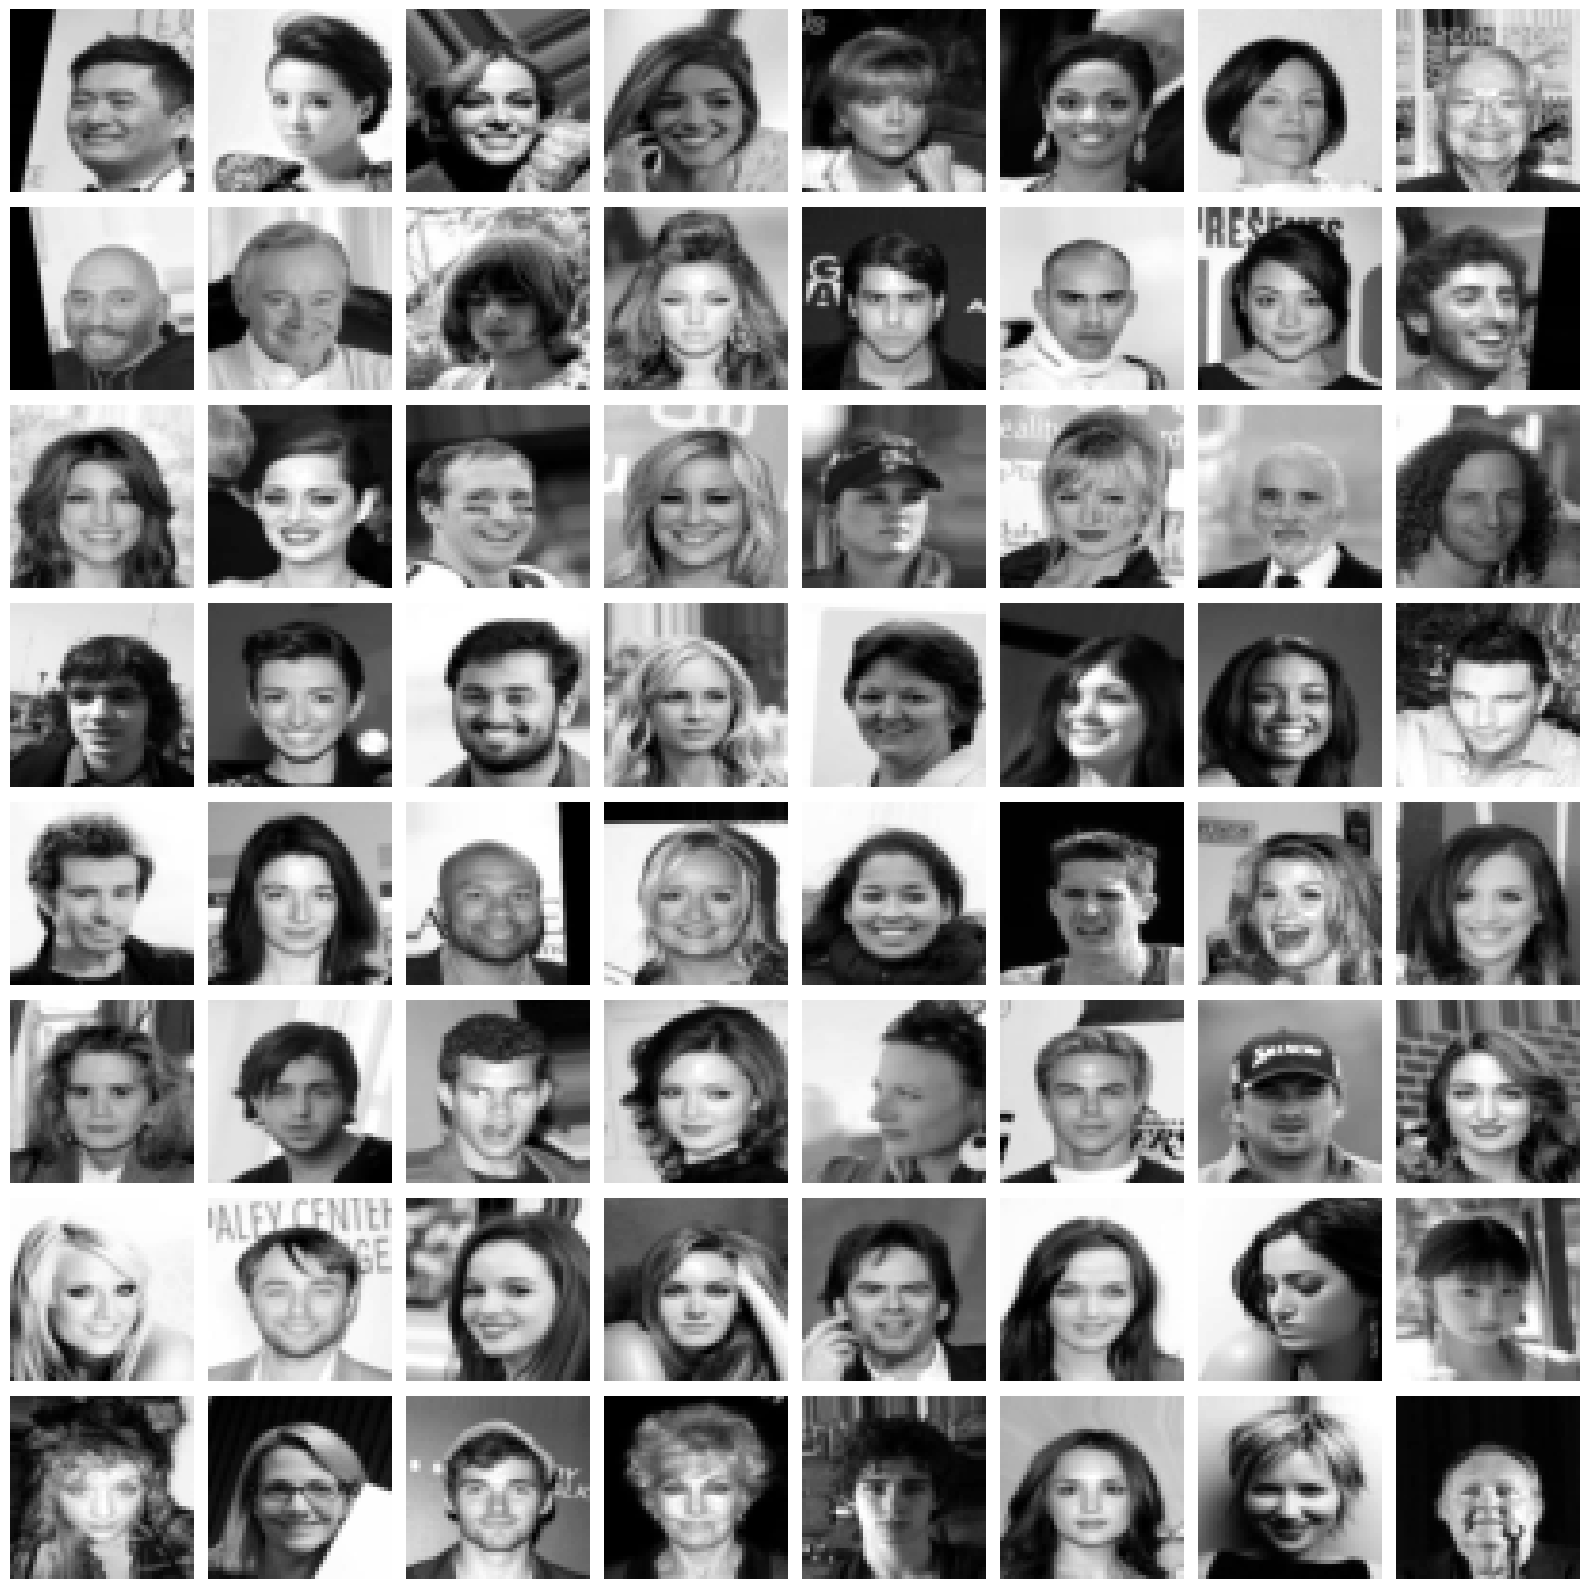

In [5]:
FIGSIZE = (16, 16)
IMAGE_SHAPE = (48, 48)
N_ROWS, N_COLS = 8, 8

_, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=FIGSIZE)
ax = ax.flatten()
for i in range(N_ROWS * N_COLS):
    img = dataset[i]
    img = img.reshape(IMAGE_SHAPE)
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

#### Training Setup

In [6]:
if torch.cuda.is_available(): 
    device = torch.device('cuda')
elif torch.backends.mps.is_available(): 
    device = torch.device('mps')
else: 
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: mps


In [ ]:
# Create generator and discriminator
DIM_NOISE = 100
generator = Generator(DIM_NOISE).to(device)
discriminator = Discriminator().to(device)

# Hyperparameters
EPOCHS = 100
BATCH_SIZE = 128
SHUFFLE = True

LR_G = 0.0002
LR_D = 0.0002

BETAS_G = (0.5, 0.999)
BETAS_D = (0.5, 0.999)

# Create the optimizer and the loss
criterion_g = GeneratorLoss(maximize=True)
optimizer_g = torch.optim.Adam(params=generator.parameters(), lr=LR_G, betas=BETAS_G, maximize=True)

criterion_d = DiscriminatorLoss()
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=LR_D, betas=BETAS_D, maximize=True)

# Load the dataset
dataloader = DataLoader(dataset, BATCH_SIZE, SHUFFLE)

In [8]:
num_params_g = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_d = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print(f'Generator has: {num_params_g} learnable parameters')
print(f'Discrimintor has: {num_params_d} learnable parameters')

Generator has: 19242304 learnable parameters
Discrimintor has: 21037201 learnable parameters


In [9]:
# Print settings
VERBOSE = True

# Plot settings
PLOTTING = True
SAVE_LOC = './celeb_faces_fake'
Z = torch.rand(size=(N_ROWS * N_COLS, DIM_NOISE), device=device) * 2 - 1

if PLOTTING:
    if not os.path.exists(SAVE_LOC):
        os.mkdir(SAVE_LOC)

#### Start Training

In [ ]:
losses_d, losses_g = [], []
N_samples = len(dataset)
for epoch in range(EPOCHS):

    total_loss_g, total_loss_d = 0.0, 0.0
    for x in dataloader:
        # x is sampled from data generating distribution x ~ p_data
        x = x.to(device)

        # z is sampled from noise prior z ~ p_noise
        z = torch.rand(size=(x.shape[0], DIM_NOISE), device=device) * 2 - 1
        D_x = discriminator(x)
        D_G_z = discriminator(generator(z))

        # update descriminator by ascending its stochastic gradient
        optimizer_d.zero_grad()
        loss_d = criterion_d(D_x, D_G_z)
        loss_d.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.9365)  
        optimizer_d.step()
        
        # z is sampled from noise prior
        # z ~ p_noise
        z = torch.rand(size=(x.shape[0], DIM_NOISE), device=device) * 2 - 1
        D_G_z = discriminator(generator(z))

        # update generator by descending its stochastic gradient
        optimizer_g.zero_grad()
        loss_g = criterion_g(D_G_z)
        loss_g.backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.9365)  
        optimizer_g.step()

        total_loss_d += loss_d.item() * x.shape[0]
        total_loss_g += loss_g.item() * z.shape[0]
    losses_d.append(total_loss_d / N_samples)
    losses_g.append(total_loss_g / N_samples)

    if VERBOSE: 
        print(
            f'epoch: {epoch}\t' 
            f'generator loss: {(total_loss_g/N_samples):.4f}\t'
            f'discriminator loss: {(total_loss_d/N_samples):.4f}'
        )

    if PLOTTING:
        G_z = generator(Z)
        fig, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=FIGSIZE)
        ax = ax.flatten()
        for i in range(N_ROWS * N_COLS):
            img = G_z[i].cpu().detach().numpy().reshape(IMAGE_SHAPE)
            ax[i].imshow(img, cmap='gray')
            ax[i].axis('off') 
        plt.tight_layout()
        fig.savefig(os.path.join(SAVE_LOC, f'fake_celeb_{epoch}'))
        plt.close(fig)

epoch: 0	generator loss: -0.9457	discriminator loss: -1.2354
epoch: 1	generator loss: -0.9577	discriminator loss: -1.2303
epoch: 2	generator loss: -0.8790	discriminator loss: -1.3090
epoch: 3	generator loss: -0.8320	discriminator loss: -1.3349
epoch: 4	generator loss: -0.7972	discriminator loss: -1.3808
epoch: 5	generator loss: -0.7937	discriminator loss: -1.3658
epoch: 6	generator loss: -0.7949	discriminator loss: -1.3627


#### GAN Training Losses

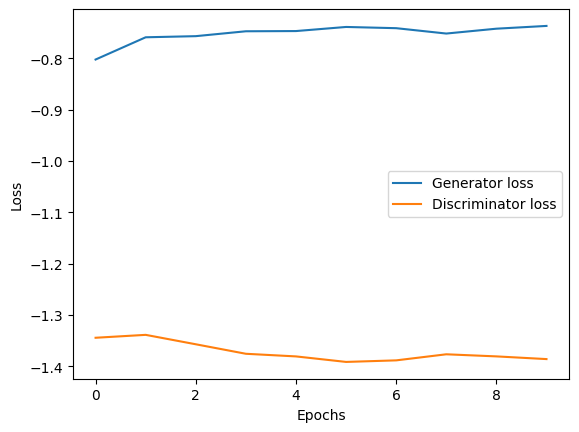

In [ ]:
_, ax = plt.subplots()
ax.plot(np.arange(EPOCHS), losses_g, label='Generator loss')
ax.plot(np.arange(EPOCHS), losses_d, label='Discriminator loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.legend()
plt.show()

#### Visualizing Fake Data

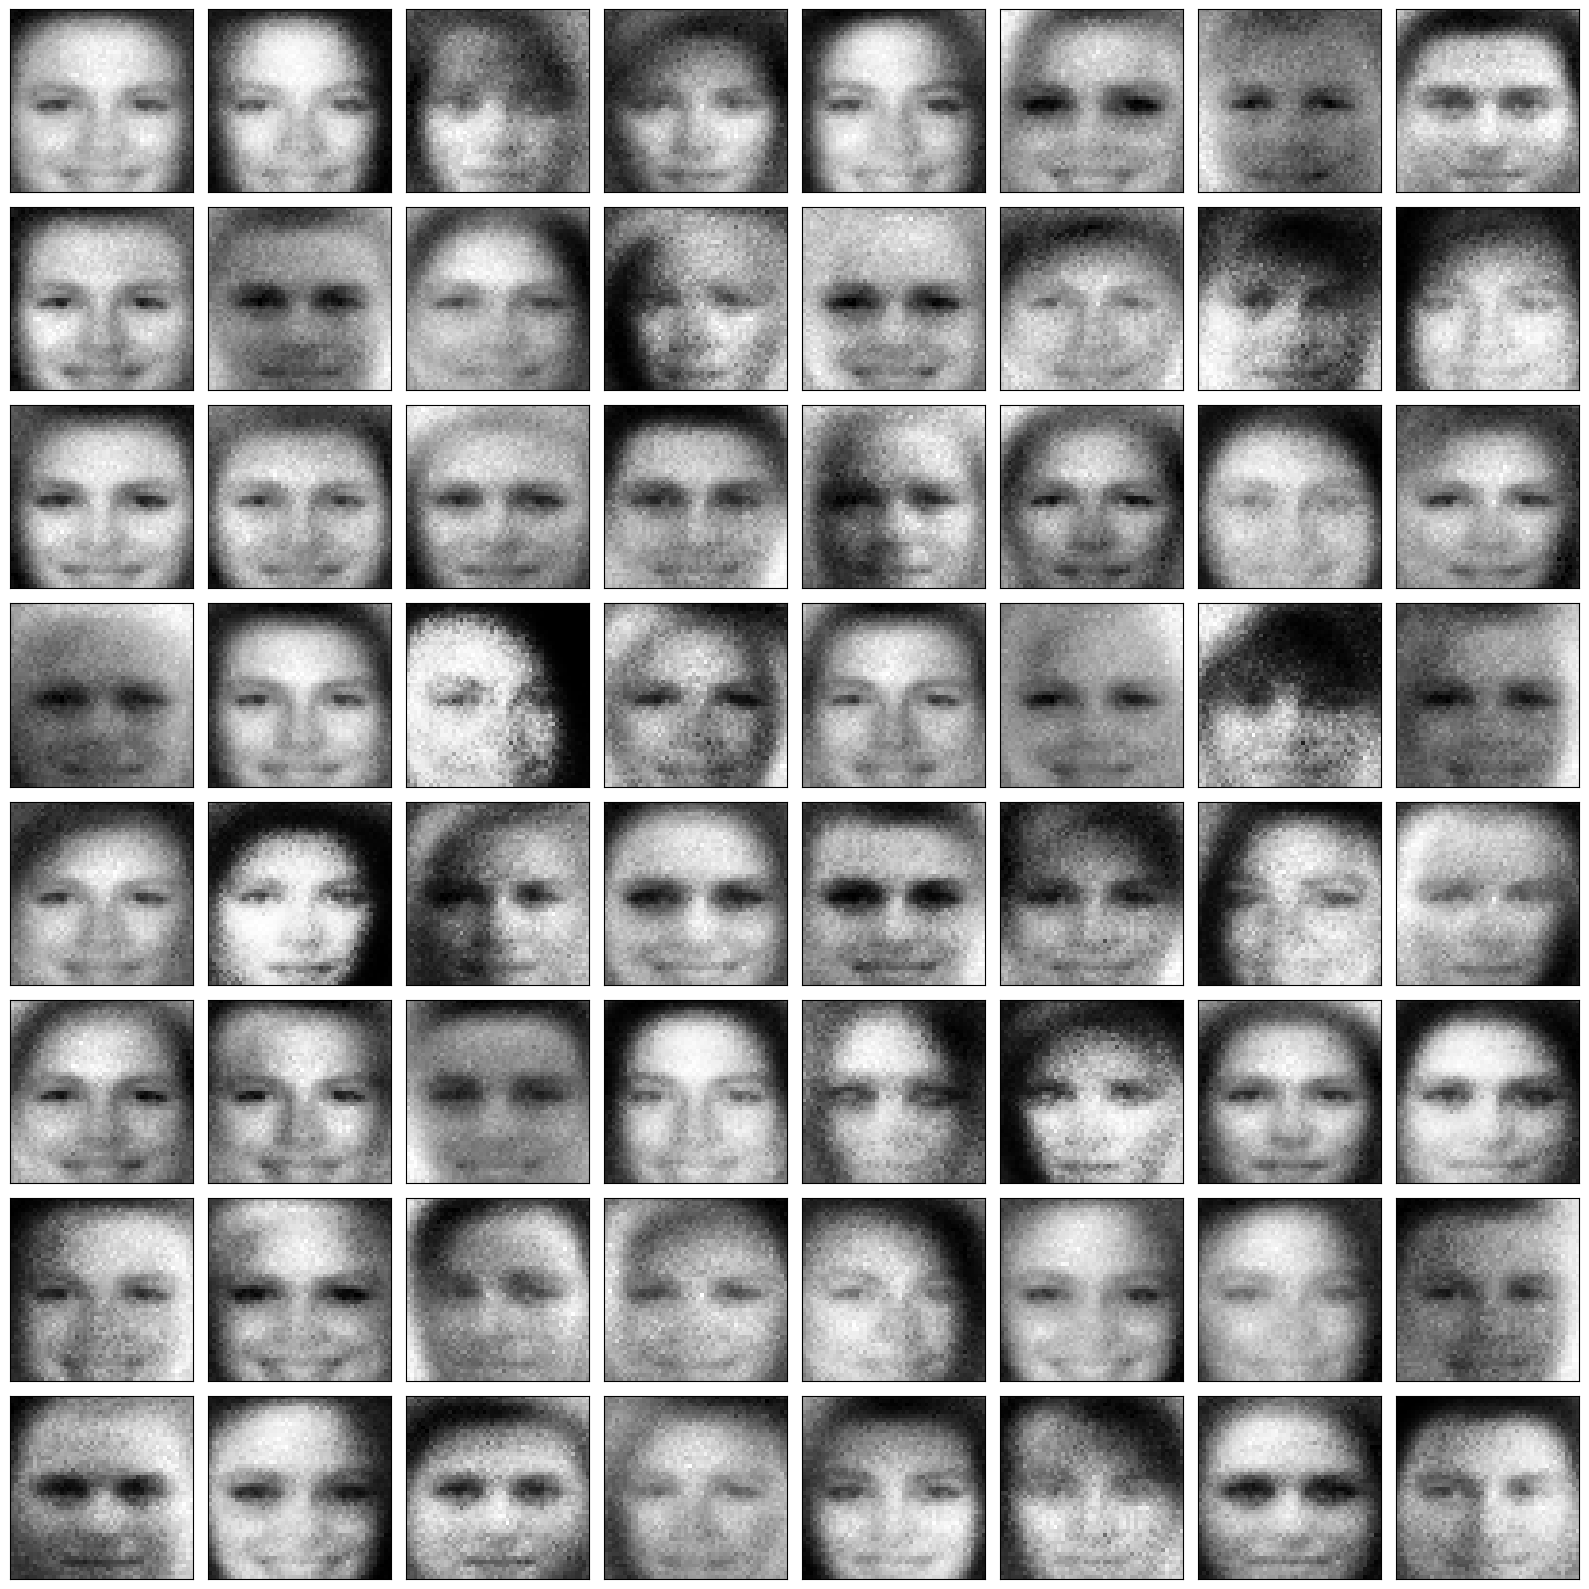

In [ ]:
Z = torch.rand(size=(N_ROWS * N_COLS, DIM_NOISE), device=device) * 2 - 1
data_fake = generator(Z)

_, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=FIGSIZE)
ax = ax.flatten()
for i in range(N_ROWS * N_COLS):
    img = data_fake[i].cpu().detach().numpy().reshape(IMAGE_SHAPE)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_xticks([]),
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()